<font color = green>

# Logistic Regression #
</font>

<font color = green>

## Import necessary packages

</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py # common package to interact with a dataset that is stored on an H5 file.
import scipy
from PIL import Image
import scipy.misc
from scipy.misc import imresize
import math
# from PIL import Image
from scipy import ndimage

c:\python\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


<font color = green>

## Overview of the Problem set ##
</font>

**Problem Statement** 
Dataset ("data.h5") contains:
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB) (each image is square: height = num_px and width = num_px).

Task is to build a simple image-classification algorithm that can correctly classify pictures as cat or non-cat.

<font color = green>

## Overview dataset 

</font>

<font color = green>

### Create shortcut for path

</font>

In [2]:
import os
cwd= os.getcwd() # current working directory
path = os.path.join(cwd,'data') 
print (path)

C:\Users\Romeo\crowdin\task\7\data


<font color = green>

### Load dataset

</font>

In [3]:
def load_dataset():
    file_name=  os.path.join(path , 'train_catvnoncat.h5')
    train_dataset = h5py.File(file_name, "r")
    X_train = np.array(train_dataset["train_set_x"][:]) # your train set features
    Y_train = np.array(train_dataset["train_set_y"][:]) # your train set labels
    
    file_name=  os.path.join(path , 'test_catvnoncat.h5')
    test_dataset = h5py.File(file_name, "r")
    X_test = np.array(test_dataset["test_set_x"][:]) # your test set features
    Y_test = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = ['non-cat','cat']
    
    Y_train = Y_train.reshape(-1,1)
    Y_test = Y_test.reshape(-1,1)
    
    return X_train, Y_train, X_test, Y_test, classes

In [4]:
X_train,Y_train, X_test, Y_test, classes = load_dataset()
# Note : in case file not found, uncomment to print path in previous step and correct to necessary exrension

In [5]:
print ('X_train.shape= ',X_train.shape)
print ('X_test.shape= ',X_test.shape)
print ('Y_train.shape= ',Y_train.shape)
print ('Y_test.shape= ',Y_test.shape)

X_train.shape=  (209, 64, 64, 3)
X_test.shape=  (50, 64, 64, 3)
Y_train.shape=  (209, 1)
Y_test.shape=  (50, 1)


In [6]:
# YOUR_CODE.   get m_train, num_px and m_test
# START_CODE 
m_train = X_train.shape[0]
num_px = X_train.shape[1]
m_test = X_test.shape[0]
# END_CODE 

<font color = blue >

### Check result

</font>


In [7]:
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")


Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)


<font color = blue >

### Expected output

</font>

<br> `Number of training examples: m_train = 209` 
<br> `Number of testing examples: m_test = 50` 
<br> `Height/Width of each image: num_px = 64` 
<br> `Each image is of size: (64, 64, 3)` 



<font color = green>

### Review some examples

</font>

y = [1], it's a 'cat' picture.


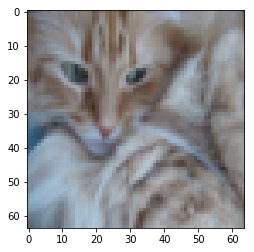

In [8]:
# Example of a picture
index = 2
plt.imshow(X_train[index])
print ("y = " + str(Y_train[index,:]) + ", it's a '" + classes[np.squeeze(Y_train[index,:])] +  "' picture.")

y = [0], it's a 'non-cat' picture.


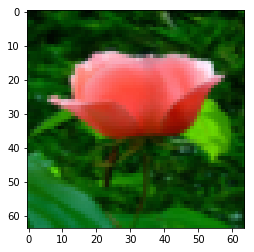

In [9]:
index = 3
plt.imshow(X_train[index])
print ("y = " + str(Y_train[index,:]) + ", it's a '" + classes[np.squeeze(Y_train[index,:])] +  "' picture.")

In [10]:
print ('Label 1 count:', np.sum(Y_train!=0))
print ('Label 0 count:', np.sum(Y_train==0))

Label 1 count: 72
Label 0 count: 137


<font color = green>

## Flatten features

</font>

In [11]:
# YOUR_CODE. Reshape the training and test set to shape (number_of_samples,  num_px*num_px*3)
# START_CODE 
X_train_flatten = X_train.reshape(X_train.shape[0], num_px*num_px*3)
X_test_flatten =  X_test.reshape(X_test.shape[0], num_px*num_px*3)
# END_CODE 

<font color = blue >

### Check result

</font>


In [12]:
print ("train_set_x_flatten shape: {}".format(X_train_flatten.shape))
print ("test_set_x_flatten shape: {}".format(X_test_flatten.shape))
print ("sanity check after reshaping: {}".format(X_train_flatten[0, :5]))

train_set_x_flatten shape: (209, 12288)
test_set_x_flatten shape: (50, 12288)
sanity check after reshaping: [17 31 56 22 33]


<font color = blue >

### Expected Output

</font>


<br>`X_train_flattern shape: (209,12288)` 
<br>`X_test_flattern shape: (50,12288)`
<br>`sanity check after reshaping: [17 31 56 22 33]`


<font color = green>

## Normalize features

</font>
To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

For picture datasets, it is almost the same as MinMaxScaler  to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [13]:
X_train_scaled = X_train_flatten/255.
X_test_scaled = X_test_flatten/255.

<font color = green>

## sigmoid function

</font>

$ g(z) = \frac{1}{1 + e^{-z}}$

In [14]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    g -- sigmoid(z)
    """

    # YOUR_CODE. Implement sigmoid function
    # START_CODE 
    g = 1 / (1 + np.exp(-z))
    # END_CODE 
    
    return g


<font color = blue >

### Check result

</font>


In [15]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


<font color = blue >

### Expected Output

</font>

<br>`sigmoid([0, 2]) [0.5        0.88079708]`

<font color = green>

## Initialize parameters

</font>


In [16]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (1,dim) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (1,dim)
    b -- initialized scalar (corresponds to the bias)
    """
    
    # YOUR_CODE.  Initialize b to zero and w as a vector of zeros. 
    # START_CODE   
    w = np.zeros(dim).reshape(1,-1)
    b = 0
    # END_CODE 

    assert(w.shape == (1,dim))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

<font color = blue >

### Check result

</font>


In [17]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0. 0.]]
b = 0


<font color = blue >

### Expected Output

</font>
<br> `w  [[ 0.  0.]]`
<br>`b 0`

**Note**: For image inputs, w will be of shape (1, num_px $\times$ num_px $\times$ 3).

<font color = green>

##  Forward and Backward propagation

</font>


Computing cost function is called "forward" and computing derivatives (gradient) is called "backward" propagation

**Forward Propagation:**
- compute  $Z = b + X \,@\,  w.T  \quad([[z^{(0)}], [z^{(1)}], ..., [z^{(m-1)}]])$
- compute  $A = g(Z)  \quad([[a^{(0)}], [a^{(1)}], ..., [a^{(m-1)}]])$
- calculate the cost function: $J = -\frac{1}{m}\sum_{i=0}^{m-1}(y^{(i)}\log(a^{(i)})+(1-Y^{(i)})\log(1-a^{(i)}))$

**Backward Propagation:** 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}(A-Y)^T @X \quad \quad 
 \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [18]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (1,num_px * num_px * 3)
    b -- bias, a scalar
    X -- data of size (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (number of examples,1)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    m = X.shape[0]
 
    # YOUR_CODE.  implement forward propagation 
    # START_CODE   
    Z= b+X@w.T
    A=  sigmoid(Z)
    cost = -1/(m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))    
    # END_CODE 
    
    # YOUR_CODE.  Implement Backward propahation 
    # START_CODE   
    dJ_dw = 1/m*(A-Y).T@X
    dJ_db = 1/m*np.sum(A-Y)
   # END_CODE 

    assert(dJ_dw.shape == w.shape)
    assert(dJ_db.dtype == float)
    assert(cost.dtype == float)
    
    grads = {"dJ_dw": dJ_dw,
             "dJ_db": dJ_db}
    
    return grads, cost

<font color = blue >

### Check result

</font>


In [19]:
w, b, X, Y = np.array([[1., 2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]).T, np.array([[1,0,1]]).T
grads, cost = propagate(w, b, X, Y)
print ("dJ_dw = " + str(grads["dJ_dw"]))
print ("dJ_db = " + str(grads["dJ_db"]))
print ("cost = " + str(cost))

dJ_dw = [[0.99845601 2.39507239]]
dJ_db = 0.001455578136784208
cost = 5.801545319394553


<font color = blue >

### Expected Output
</font>


<br>`dJ_dw = [[0.99845601 2.39507239]]`
<br>`dJ_db = 0.00145557813678`
<br>`cost = 5.801545319394553`

<font color = green>

##   Optimization
</font>

In [20]:
def optimize(w, b, X, Y, num_iterations, learning_rate, verbose = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (1,num_px * num_px * 3)
    b -- bias, a scalar
    X -- data of size (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (number of examples,1)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
   
    costs = [] # keep history for plotting if necessary 
    
    for i in range(num_iterations):        

    
        # YOUR_CODE.  Call to compute cost and gradient 
        # START_CODE   
        grads, cost = propagate(w, b, X, Y)
        # END_CODE 
        
        # Retrieve derivatives from grads
        dJ_dw = grads["dJ_dw"]
        dJ_db = grads["dJ_db"]
        
        # YOUR_CODE.  Update paramaters 
        # START_CODE   
        b= b-learning_rate*dJ_db
        w= w-learning_rate*dJ_dw
        # END_CODE 
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if verbose and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dJ_dw": dJ_dw,
             "dJ_db": dJ_db}
    
    return params, grads, costs

<font color = blue >

### Check result

</font>


In [21]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, verbose = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dJ_dw"]))
print ("db = " + str(grads["dJ_db"]))

w = [[0.19033591 0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042 1.41625495]]
db = 0.21919450454067657


<font color = blue >

### Expected Output
</font>


<br>`w = [[0.19033591  0.12259159]]`
<br>`b = 1.92535983008`
<br>`dw = [[0.67752042  1.41625495]]`
<br>`db= 0.219194504541`

<font color = green>

##  Predict
</font>

1. Calculate $\hat{Y} = A = g(b + X @ w.T)$
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), store the predictions in a vector `Y_prediction`. Try to avoid `for loop`  but use  vectorized way if possible.

In [22]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w - weights, a numpy array of size (1,num_px * num_px * 3)
    b - bias, a scalar
    X - data of size (number of examples, num_px * num_px * 3)
    
    Returns:
    Y_prediction - a numpy array of shape (number of examples, 1) containing all predictions (0/1) for the examples in X
    '''
    m,n = X.shape
    assert (w.shape==(1,n))
 
    # YOUR_CODE.  Compute "A" predicting the probabilities of a cat being present in the picture
    # START_CODE   
    A= sigmoid(b+X@w.T)
    # END_CODE 

    # YOUR_CODE.  Convert probabilities to actual predictions 0 or 1 
    # START_CODE  

    Y_prediction=[]        
    def myfunc(a):
        if a  <= 0.5:
            return 0
        else:
            return 1
    vfunc = np.vectorize(myfunc)
    Y_prediction=vfunc(A)
    # END_CODE 
    
    assert(Y_prediction.shape == (m, 1))
    
    return Y_prediction

<font color = blue >

### Check result

</font>


In [23]:
w = np.array([[0.1124579],[0.23106775]]).T
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]]).T
print ("predictions = \n{}".format (predict(w, b, X)))

predictions = 
[[1]
 [1]
 [0]]


<font color = blue >

### Expected Output
</font>

<br>`predictions=`
<br>`[[1]`
<br>` [1]`
<br>` [0]]`



<font color = green>

##   Model
</font>



In [24]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, verbose = False):
    """
    Builds the logistic regression model by calling the functions implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (number of examples, num_px * num_px * 3)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (number of examples,1)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    res -- dictionary containing information about the model.
    """
    
    # YOUR_CODE.
    # START_CODE   
    #  initialize parameters
    dim = X_train.shape[1]
    w, b = np.zeros(dim).reshape(1,-1), 0
    
    # run gradient descent 
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, verbose)
    
    # retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    # END_CODE 

    # Print train/test Errors
    print("train accuracy= {:.3%}".format(np.mean(Y_prediction_train == Y_train)))
    print("test accuracy= {:.3%}".format(np.mean(Y_prediction_test == Y_test)))
    
    res = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return res

<font color = blue >

### Check result

</font>


In [25]:
w.shape[1]


2

In [26]:
res = model(X_train= X_train_scaled,
            Y_train=Y_train, 
            X_test=X_test_scaled, 
            Y_test= Y_test, 
            num_iterations = 2000, 
            learning_rate = 0.005, 
            verbose = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy= 99.043%
test accuracy= 70.000%


<font color = blue >

### Expected Output
</font>

<br>`Cost after iteration 0: 0.693147`
<br>`Cost after iteration 100: 0.584508`

<br>$\vdots$
<br>`Cost after iteration 1900: 0.140872`
<br>`train accuracy= 99.043%`
<br>`test accuracy=  70.000%`

<font color = green>

##   Visualize prediction
</font>



y_predicted = 1 , you predicted that it is a non-cat picture.


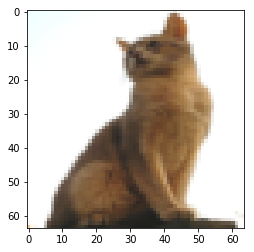

In [27]:
index = 6


plt.imshow(X_test[index,:].reshape(num_px, num_px, 3))
print ('y_predicted = {} , you predicted that it is a {} picture.'.format(Y_test[index,0],
     classes[res["Y_prediction_test"][index,0]]))


y_predicted = 1 , you predicted that it is a non-cat picture.


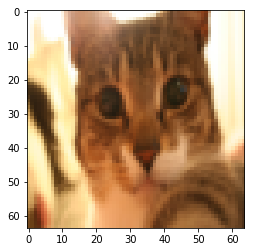

In [28]:
# index = 6 is example of a picture that was wrongly classified.
index = 11

plt.imshow(X_test[index,:].reshape(num_px, num_px, 3))
print ('y_predicted = {} , you predicted that it is a {} picture.'.format(Y_test[index,0],
     classes[res["Y_prediction_test"][index,0]]))


<font color = green>

##  Test with your image
</font>



c:\python\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


y = 1 , your algorithm predicts a cat picture.


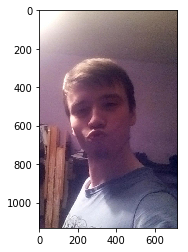

In [31]:
file_name=  os.path.join(path , 'image_file_name.jpg')

# Image  is preprocessed to fit algorithm
image = np.array(plt.imread(file_name))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3))
my_predicted_image = predict(res["w"], res["b"], my_image)

plt.imshow(image)
print('y = {} , your algorithm predicts a {} picture.'.
      format(np.squeeze(my_predicted_image),classes[np.squeeze(my_predicted_image)]))

<font color = green>

##  Sklearn implementation
</font>



In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
y_train = np.squeeze(Y_train) # LogisticRegression requires 1d input for y
clf = LogisticRegression().fit(X_train_scaled, y_train)

c:\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [34]:
print("train accuracy= {:.3%}".format(clf.score (X_train_scaled, y_train)))
y_test = np.squeeze(Y_test)
print("test accuracy= {:.3%}".format(clf.score (X_test_scaled, y_test)))

train accuracy= 100.000%
test accuracy= 72.000%


In [35]:
print('y = {} , sklearn algorithm predicts a {} picture.'.
      format(np.squeeze(clf.predict(my_image)),classes[np.squeeze(clf.predict(my_image))]))                                          

y = 1 , sklearn algorithm predicts a cat picture.


<font color = green>

###  Additional functions for visualization
</font>



In [36]:
%matplotlib notebook

In [37]:
def plot_decision_boundary(clf, X_train, y_train, X_test=None, y_test= None, title=None, precision=0.01,plot_symbol_size = 50, ax= None,  is_extended=True):

    '''    
    Draws the binary decision boundary for X that is nor required additional features and transformation (like polynomial)
    '''
    # Create color maps - required by pcolormesh
    from matplotlib.colors import  ListedColormap
    colors_for_points = np.array(['grey', 'orange']) # neg/pos
    colors_for_areas = np.array(['grey', 'orange']) # neg/pos  # alpha is applied later 
    cmap_light = ListedColormap(colors_for_areas)
    

 
    
    mesh_step_size = precision #.01  # step size in the mesh
    if X_test is None or y_test is None:
        show_test= False
        X= X_train
    else:
        show_test= True
        X= np.concatenate([X_train,X_test], axis=0)
    x1_min, x1_max = X[:, 0].min() - .1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - .1, X[:, 1].max() + 0.1
    # Create grids of pairs
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, mesh_step_size),
                         np.arange(x2_min, x2_max, mesh_step_size))
    # Flatten all samples 
    target_samples_grid= (np.c_[xx1.ravel(), xx2.ravel()])

    print ('Call prediction for all grid values (precision of drawing = {},\n you may configure to speed up e.g. precision=0.05)'.format(precision))
    Z = clf.predict(target_samples_grid)

    # Reshape the result to original meshgrid shape 
    Z = Z.reshape(xx1.shape)
    
    if ax:
        plt.sca(ax)
    
    # Plot all meshgrid prediction      
    plt.pcolormesh(xx1, xx2,Z, cmap = cmap_light, alpha=0.2)

    # Plot train set
    plt.scatter(X_train[:, 0], X_train[:, 1], s=plot_symbol_size, 
                c=colors_for_points[y_train.ravel()], edgecolor = 'black',alpha=0.6)
    # Plot test set
    if show_test:
        plt.scatter(X_test[:, 0], X_test[:, 1], marker='^', s=plot_symbol_size, 
                c=colors_for_points[y_test.ravel()],edgecolor = 'black',alpha=0.6)
    if  is_extended:
        # Create legend  
        import matplotlib.patches as mpatches # use to assign lavels for colored points 
        patch0 = mpatches.Patch(color=colors_for_points[0], label='negative')
        patch1 = mpatches.Patch(color=colors_for_points[1], label='positive')
        plt.legend(handles=[patch0, patch1])
    plt.title(title)
    if is_extended:
        plt.xlabel('feature 1')
        plt.ylabel('feature 2')
    else:
        plt.tick_params(
        top =False,
        bottom= False,
        left  = False,
        labelleft = False, 
        labelbottom = False
        )

   
    
def plot_data_logistic_regression(X,y,legend_loc= 1, title= None):
    '''
    :param X: 2 dimensional ndarray
    :param y:  1 dimensional ndarray. Use y.ravel() if necessary
    :return:
    '''

    positive_indices = (y == 1)
    negative_indices = (y == 0)
#     import matplotlib as mpl
    colors_for_points = ['grey', 'orange'] # neg/pos

    plt.scatter(X[negative_indices][:,0], X[negative_indices][:,1], s=40, c=colors_for_points [0], edgecolor = 'black', label='negative', alpha = 0.7)
    plt.scatter(X[positive_indices][:,0], X[positive_indices][:,1], s=40, c=colors_for_points [1], edgecolor = 'black',label='positive', alpha = 0.7)
    plt.title(title)
    plt.legend(loc= legend_loc)



<font color = green>

###  Make classification
</font>



In [38]:
from sklearn.datasets import make_classification
Xc_2, yc_2= make_classification(n_samples=100,
                                n_features=2,
                                n_informative=2,
                                n_redundant=0,
                                random_state=2018,
                                n_clusters_per_class=1,
                                flip_y = 0.1,
                                class_sep = 0.8)

<IPython.core.display.Javascript object>


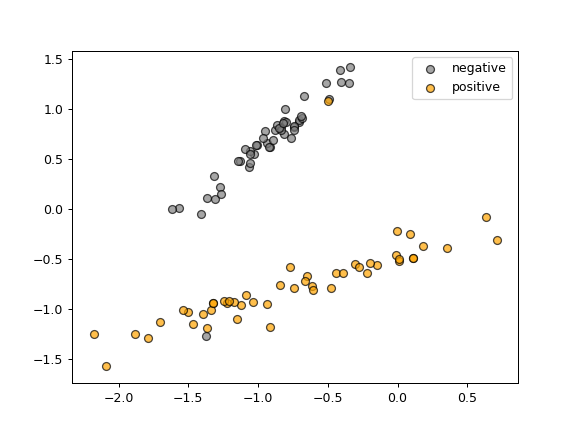

In [39]:
plt.figure()    
plot_data_logistic_regression(Xc_2,yc_2)


In [40]:
from sklearn.model_selection import train_test_split
C = 1000
X_train, X_test, y_train, y_test = train_test_split(Xc_2, yc_2, random_state = 0)
clf = LogisticRegression(C=C).fit(X_train, y_train)
print('\Make Regression')
print ('Xc_2.shape= {}'.format(Xc_2.shape))
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

\Make Regression
Xc_2.shape= (100, 2)
Accuracy of Logistic regression classifier on training set: 0.99
Accuracy of Logistic regression classifier on test set: 0.92


c:\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<IPython.core.display.Javascript object>


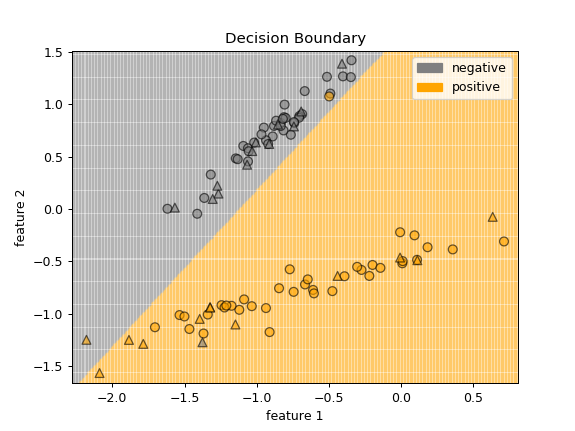

Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)


In [41]:
plt.figure()    
plot_decision_boundary(clf, X_train, y_train, X_test, y_test, title='Decision Boundary',precision=0.01, plot_symbol_size = 50)
